# Stereo Robot Navigation
The objective of this project is to sense information concerning the space in front a moving vehicle, given a video sequence taken by a stereo camera.

The main task of the project requires the following steps:
1.  Computing the disparity map in a central area of the reference frame (e.g. a squared area of size 60x60, 80x80 o 100x100 pixels), so to sense distances in  the  portion  of  the  environment  which would  be  travelled  by  the  vehicle 
should it keep a straight trajectory.   
2.  Estimate a <i>main disparity</i> (<b>$d_{main}$</b>) for the frontal (wrt the camera) portion of the  environment  based  on  the  disparity  map  of  the  central  area  of  the reference frame computed in the previous step, e.g. by choosing the average disparity or the most frequent disparity within the map.    
3.  Determine the distance (z, in mm) of the obstacle wrt to the moving vehicle based on the main disparities (in pixel) estimated from each pair of frames:

$$z(mm)=\frac{b(mm)*f(pixel)}{d_{main}(pixel)}$$

4.  Generate a suitable output to convey to the user, in each pair of frame, the 
information related to the distance (converted in meters) from the camera to 
the obstacle. Moreover, an alarm should be generated whenever the distance 
turns out below 0.8 meters.  
5.  Compute  the  real  dimensions  in  <i>mm</i>  (W,H)  of  the  chessboard  pattern 
present in the scene. Purposely,  the  OpenCV  functions  `cvFindChessboardCorners` and `cvDrawChessboardCorners` may  be  deployed  to,  respectively,  find and display the pixel coordinates of the internal corners of the chessboard. Then, assuming  the chessboard pattern  to be  parallel to the image plane of 
the  stereo  sensor,  the  real  dimensions  of  the  pattern  can  be  obtained  from 
their pixel dimensions (w,h) by the following formulas: 


In this file I will analize only a single frame, trying different approaches and giving a detailed explanation for every step. In the file **`FinalResult.ipynb`** I will apply the best methods found here to elaborate the entire video.

### Import

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import time
import math

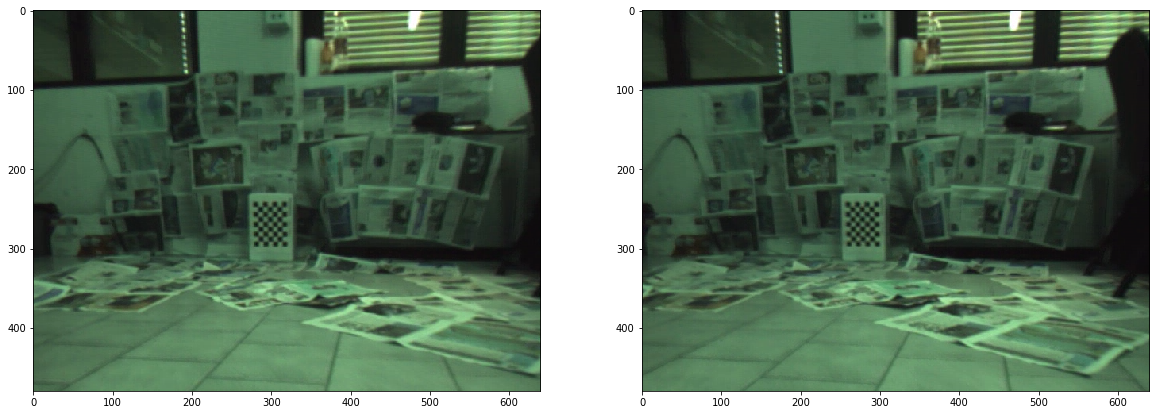

In [2]:
# Extract a frame from the middle of the video
capL = cv2.VideoCapture('Video/robotL.avi')
capR = cv2.VideoCapture('Video/robotR.avi')
for i in range(0, 30):
    ret, frameL = capL.read()
    ret, frameR = capR.read()

frameL_gray = cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)
frameR_gray = cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(frameL)
plt.subplot(1,2,2)
plt.imshow(frameR)
plt.show()

## 1. Compute the disparity map
To get information about the depth of objects in front of the camera, first we need to build a disparity map using the stereo pair of frame. Chosen a reference frame (in this case the left), to compute the disparity map we have to search for the corresponding pixel in the other image. In order to do so, we can compare the intensities of two squared windows centered at the points. Such a comparison can be done through the computation of a dissimilarity or a similarity measure between the two windows. Since the two video are already rectified, the pixel need to be sought only along the same row.

### Dissimilarity/Similarity measure
I implemented four different dissimilarity/similarity measure: the sum of absolute differences (SAD), the sum of squared differences (SSD), the normalized cross-correlation (NCC), and the zero-means normalized cross-correlation (ZNCC).

In [3]:
def SAD(window1, window2):
    return np.sum(np.abs(window1 - window2))

def SSD(window1, window2):
    return np.sum(np.square(window1 - window2))

def NCC(window1, window2):
    return np.dot(window1.flatten(), window2.flatten()) / (np.linalg.norm(window1)*np.linalg.norm(window2))

def ZNCC(window1, window2):
    m1 = np.average(window1)
    m2 = np.average(window2)
    return np.dot(window1.flatten()-m1, window2.flatten()-m2) / (np.linalg.norm(window1-m1)*np.linalg.norm(window2-m2))
    

### Disparity map function
This first implementation is very straightforward: it loops through every pixel in the left image, and search the corresponding one in the right image along the disparity range.

In [4]:
disparity_range = range(0, 128)

# Dissimilarity/Similarity measure
M_SAD = 0
M_SSD = 1
M_NCC = 2
M_ZNCC = 3

def computeDisparityMap(left_image, right_image, area_size, block_size, 
                        disparity_range=disparity_range, measure = M_SAD):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")
    
    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")

    disparity_map = np.zeros((left_image.shape[0], left_image.shape[1]), dtype=int)
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    n = block_size // 2      #block_size = 2n+1

    # Extremes of the area of which we will calculate the disparity
    v_min = (left_image.shape[0]-area_size)//2
    v_max = (left_image.shape[0]+area_size)//2
    u_min = (left_image.shape[1]-area_size)//2
    u_max = (left_image.shape[1]+area_size)//2


    for v in range(v_min, v_max):
        for u in range(u_min, u_max):
            # variables to store the best value
            best_value = 0
            u_R = 0

            if measure == M_SAD or measure == M_SSD:
                best_value = sys.maxsize
            if measure == M_NCC or measure == M_ZNCC:
                best_value = -sys.maxsize

            # We will use the left image as the reference image
            template = left_image_f[v-n:v+n+1, u-n:u+n+1]

            for i in disparity_range:
                # compute the similarity or dissimilarity between two windows             
                # we will slide over the left
                window = right_image_f[v-n:v+n+1, u-n-i:u+n-i+1]
                
                if measure == M_SAD:
                    sad = SAD(template, window)
                    if sad < best_value:
                        best_value = sad
                        u_R = u-i
                
                elif measure == M_SSD:
                    ssd = SSD(template, window)
                    if ssd < best_value:
                        best_value = ssd
                        u_R = u-i
                
                elif measure == M_NCC:
                    ncc = NCC(template, window)
                    if ncc > best_value:
                        best_value = ncc
                        u_R = u-i
                
                elif measure == M_ZNCC:
                    zncc = ZNCC(template, window)
                    if zncc > best_value:
                        best_value = zncc
                        u_R = u-i


            disparity_map[v,u] = u - u_R   #left - right
            
    return disparity_map[v_min:v_max, u_min:u_max]

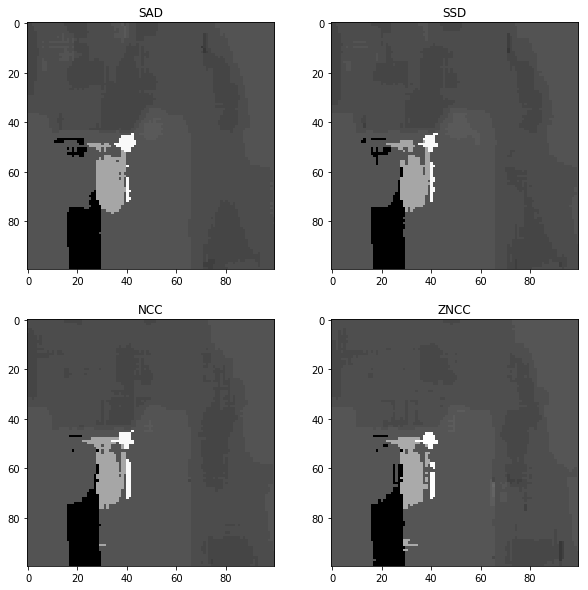

SAD execution time: 7.80s
SSD execution time: 8.15s
NCC execution time: 15.84s
ZNCC execution time: 48.18s


In [5]:
time1 = time.time()
sad_disparity_map = computeDisparityMap(frameL_gray, frameR_gray, area_size=100, block_size=15, measure=M_SAD)
time2 = time.time()
ssd_disparity_map = computeDisparityMap(frameL_gray, frameR_gray, area_size=100, block_size=15, measure=M_SSD)
time3 = time.time()
ncc_disparity_map = computeDisparityMap(frameL_gray, frameR_gray, area_size=100, block_size=15, measure=M_NCC)
time4 = time.time()
zncc_disparity_map = computeDisparityMap(frameL_gray, frameR_gray, area_size=100, block_size=15, measure=M_ZNCC)
time5 = time.time()

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("SAD")
plt.imshow(sad_disparity_map, "gray")
plt.subplot(2,2,2)
plt.title("SSD")
plt.imshow(ssd_disparity_map, "gray")
plt.subplot(2,2,3)
plt.title("NCC")
plt.imshow(ncc_disparity_map, "gray")
plt.subplot(2,2,4)
plt.title("ZNCC")
plt.imshow(zncc_disparity_map, "gray")
plt.show()

print("SAD execution time: {:.2f}s".format(time2-time1))
print("SSD execution time: {:.2f}s".format(time3-time2))
print("NCC execution time: {:.2f}s".format(time4-time3))
print("ZNCC execution time: {:.2f}s".format(time5-time4))

The first thing we can notice is that the computation times of NCC and ZNCC are significantly higher than SAD or SSD. Excluding that, there are no apparent differences between the various disparity maps. Therefore, from now on I will use SAD.

Note that we could get significantly better times using FTT (Fast Fourier Transform), however, I am only considering qualitative differences at this time. Later considerations will be made to improve performance.

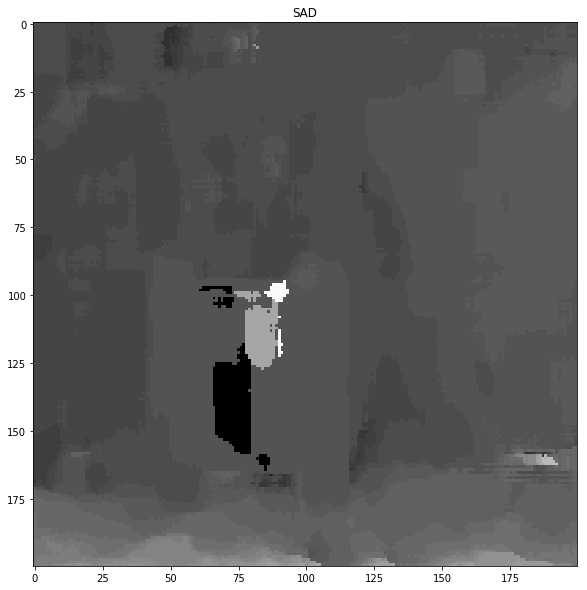

In [6]:
# We compute a larger disparity map for better visualization
disparity_map = computeDisparityMap(frameL_gray, frameR_gray, area_size=200, block_size=15, measure=M_SAD)

plt.figure(figsize=(10,10))
plt.title("SAD")
plt.imshow(disparity_map, "gray")
plt.show()

## 2. Estimate a *main disparity*
We can estimate a *main disparity* ($d_{main}$) for the frontal (wrt the camera) portion of 
the  environment  based  on  the  disparity  map  of  the  central  area  of  the 
reference frame computed in the previous step, e.g. by choosing the average 
disparity or the most frequent disparity within the map.

In [7]:
def computeMainDisparity(disparity_map):
    # Return average disparity
    return np.average(disparity_map)

    # Return most frequent disparity
    #return np.bincount(disparity_map.flatten()).argmax()

d_main = computeMainDisparity(disparity_map)
print("Main disparity: {:.2f}".format(d_main))

Main disparity: 20.86


## 3. Determine the distance of the obstacle
Given the focal lenght and the baseline, it's possible to determine the distance in meters starting from the disparity value:

$$z(mm)=\frac{b(mm)*f(pixel)}{d_{main}(pixel)}$$

In [8]:
baseline = 92.226   # mm
focale = 567.2      # pixel

def computeDistance(main_disparity, baseline = baseline, focal_length = focale):
    return baseline*focal_length/main_disparity

distance = computeDistance(d_main, baseline, focale)
print("Distance from the obstacle: {:.2f} mm".format(distance))

Distance from the obstacle: 2507.11 mm


## 4. Generate a suitable output to convey to the user the information related to the distance
To convey to the user the information related to the distance, I've added a textbox in the top-left corner of the reference image (in our case, the left frame), containing the distance value in meters. If the distance is under a threshold value of 0.8 meters, the textbox will be highlighted in red, otherwise in green. Also, I've highlighted in red the area of which the disparity map is computed.

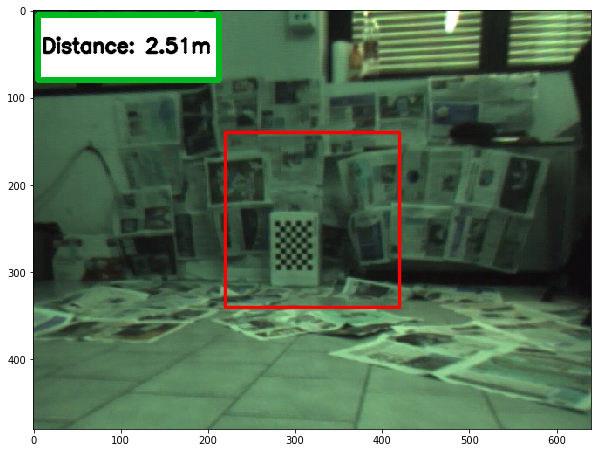

In [9]:
def generateOutputImage(img, distance, disparity_size):
    # If the value is under the threshold, the box will be red, otherwise green
    if distance <= 800:
        border_color = [158, 3, 34]
    else:
        border_color = [0, 184, 31]

    output_image = np.copy(img)
    border_thick = 5
    top_left = (border_thick, border_thick)
    bottom_right = (img.shape[1]//3, img.shape[0]//6)

    # Highlight the disparity map area
    cv2.rectangle(
        img = output_image, 
        pt1 = ((img.shape[1]-disparity_size)//2, (img.shape[0]-disparity_size)//2),
        pt2 = ((img.shape[1]+disparity_size)//2, (img.shape[0]+disparity_size)//2), 
        color = (255,0,0), 
        thickness = 2,
        lineType=cv2.LINE_AA)
    
    # Add a white rectangle area
    cv2.rectangle(
        img = output_image, 
        pt1 = top_left, 
        pt2 = bottom_right, 
        color = (255,255,255), 
        thickness = cv2.FILLED)

    # Add the colored border to the rectangle
    cv2.rectangle(
        img = output_image, 
        pt1 = top_left, 
        pt2 = bottom_right, 
        color = border_color, 
        thickness = border_thick)

    # Add the text inside the rectangle
    text = "Distance: {:.2f}m".format(distance/1000)
    cv2.putText(
        img = output_image, 
        text = text, 
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale = 0.75, 
        color = (0, 0, 0),
        thickness = 2,
        org = (border_thick+5, bottom_right[1]//2+8),
        lineType = cv2.LINE_AA)
        
    return output_image



output_image = generateOutputImage(frameL, distance, disparity_size=200)

plt.figure(figsize=(10,20))
plt.imshow(output_image)
plt.show()


## 5. Compute dimension of the chessboard
Using the function <code>findChessboardCorners</code> provided by openCV, we get the image coordinates of the corners, thereby we can determine the size of the chessboard inside the image in pixel. Assuming that the chessboard is parallel to the image plane, we can determine the real size in mm using the following formulas:

$$W(mm)=\frac{z(mm)*w(pixel)}{f(pixel)}$$

$$H(mm)=\frac{z(mm)*h(pixel)}{f(pixel)}$$

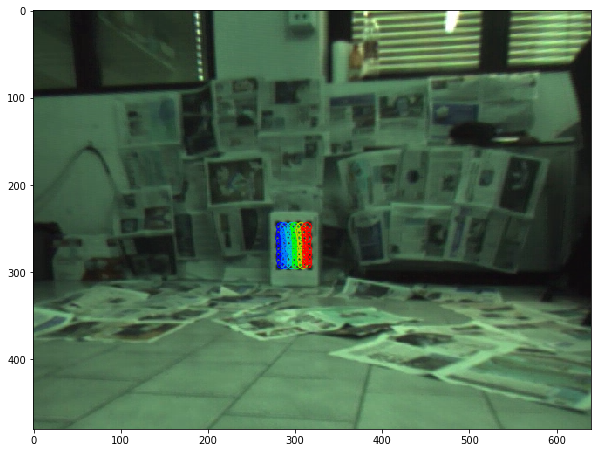

W - estimated: 127.72mm   real: 125mm
H - estimated: 185.77mm   real: 178mm


In [10]:
pattern_size = (8,6) # number of inner corner

def computeChessboardSize(img, distance, pattern_size=pattern_size):

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    # In order to use cornerSubPix, we need a single channel image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    if found:
        # Refining corner position to subpixel iteratively until criteria  max_count=30 or 
        # criteria_eps_error=1 is satisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1.)
        cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
        
        # We can assume that the pattern is parallel to the image plane
        
        # The corners are not guaranteed to be in this order, they could be reversed, but since
        # we are interested only in the length, the computation is correct in both cases
        top_right = corners[0,0,:]
        bottom_right = corners[7,0,:]
        top_left = corners[40,0,:]
        bottom_left = corners[47,0,:]

        W = distance * np.linalg.norm(top_left-top_right) / focale
        H = distance * np.linalg.norm(top_left-bottom_left) / focale

        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return W, H, img_with_corner
    else:
        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return None, None, img_with_corner



W, H, img_with_corner = computeChessboardSize(frameL, distance, pattern_size=(8,6))

plt.figure(figsize=(10,20))
plt.imshow(img_with_corner)
plt.show()

if W != None and H != None:
    print("W - estimated: {:.2f}mm   real: 125mm".format(W))
    print("H - estimated: {:.2f}mm   real: 178mm".format(H))
else:
    print("Could not detect chessboard")
    

# Improvements

## Fast disparity map
The method used previously to compute the disparity map is simple and straigthforward to comprehend, but it is not very efficient because of the various for loop utilized. Here I propose an alternative method, which is significantly faster. For each value of the disparity range, perform the absolute differences between the left image and the right image(shifted by the disparity value). Then for each pixel sum the absolute differences over a window of block_size using a convolution filter. This leads to a 3D space, which contains "max_disparity" number of SAD maps. The disparity map will be a 2D map reduced from the 3D space, taking as disparity value the indices of the minimum sad values.

(based on https://sites.google.com/site/5kk73gpu2010/assignments/stereo-vision#TOC-Update-Disparity-Map)

In [11]:
disparity_range = range(0, 128)

# Flags
R_DEFAULT = 0   # return only disparity map
R_SAD_MAP = 1   # return disparity map and the corresponding dissimilarity map
R_SAD_MAPS = 2  # return disparity map and the dissimilarity maps for each step in the dissimilarity range

def computeFastDisparityMap(left_image, right_image, area_size, block_size, disparity_range=disparity_range, flag=R_DEFAULT):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")

    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")
    
    kernel = np.ones([block_size, block_size])
    sad_maps = np.zeros([area_size, area_size, len(disparity_range)])
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    left_translation = np.float32([[1, 0, -(left_image.shape[1]-area_size)//2], 
                              [0, 1, -(left_image.shape[0]-area_size)//2]])
    
    left_ROI = cv2.warpAffine(left_image_f, left_translation, (area_size, area_size))

    for i in disparity_range:
        # The right image must be shifted each for loop
        right_translation = left_translation + ([[0,0,i],[0,0,0]])
        right_ROI = cv2.warpAffine(right_image_f, right_translation, (area_size, area_size))

        # Calculate absolute differences
        absolute_differences = np.abs(left_ROI - right_ROI)

        # Convolve with kernel and compute SAD at each point
        sad_map = cv2.filter2D(
            src = absolute_differences,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        sad_maps[:, :, i-disparity_range[0]] = sad_map
    
    # The disparity values are the indices of the minimum sad values, plus the starting value
    # of the disparity range
    disparity_map = np.argmin(sad_maps, axis=-1)
    disparity_map += disparity_range[0]

    if flag == R_DEFAULT:
        return disparity_map
    elif flag == R_SAD_MAP:
        sad_map = np.min(sad_maps, axis=-1)
        return disparity_map, sad_map
    elif flag == R_SAD_MAPS:
        return disparity_map, sad_maps

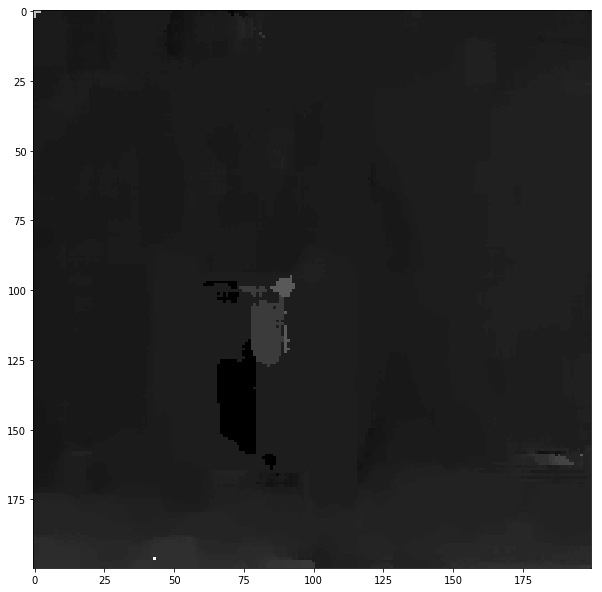

In [12]:
fast_disparity_map = computeFastDisparityMap(frameL_gray, frameR_gray, area_size=200, block_size=15)

plt.figure(figsize=(10,20))
plt.imshow(fast_disparity_map, "gray")
plt.show()

## Variable disparity range
Deploying a smaller disparity range would allow us to perform fewer calculations. However, since the minimum and maximum disparity correspond to a minimum and maximum depth range, the disparity range must be chosen carefully so that the obstacles does not fall out of the depth range. In order to do this, the disparity range is computed each frame, and is chosen in such a way to allow the main_disparity of the previous frame to lie in the middle of the range.

In [13]:
def computeDisparityRange(main_disparity):
    if main_disparity < 32:
        return range(0, 64)
    else:
        return range(int(main_disparity)-32, int(main_disparity)+32)
    

Previous main disparity: 20.86
New range: range(0, 64)


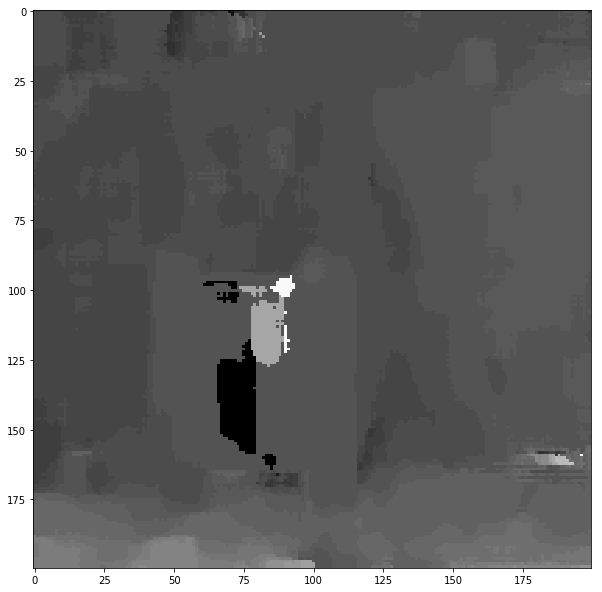

In [14]:
disparity_range = computeDisparityRange(d_main)
print("Previous main disparity: {:.2f}".format(d_main))
print("New range: {}".format(disparity_range))

disparity_map = computeFastDisparityMap(frameL_gray, frameR_gray, area_size=200, block_size=15, disparity_range=disparity_range)
plt.figure(figsize=(10,20))
plt.imshow(disparity_map, "gray")
plt.show()

## Planar view of the obstacle

The following function creates an approximate planar view of the scene, by dividing the disparity map in vertical stripes and computing the main disparity for each of them. With the assumption that the obstacles are parallel to the image plane, it's possible to compute the 3D coordinates relative to the camera and construct the planar view.

Knowing the distances in different area of the obstacle, it's also possible to approximate the orientation of the obstacle with respect to the image plane.

In [15]:
def computeObstaclesCoords(disparity_map, num_stripes):
    # For each stripe compute the main disparity value
    disparities = []
    stripe_len = disparity_map.shape[1] // num_stripes

    for i in range(0, num_stripes):
        # Average value
        disparities.append(np.average(disparity_map[:,stripe_len*i:stripe_len*(i+1)].flatten()))

        # Most frequent value
        #disparities.append(np.bincount(disparity_map[:,stripe_len*i:stripe_len*(i+1)].flatten()).argmax())
    
    # Compute the center point of each stripe
    width = disparity_map.shape[1]
    height = disparity_map.shape[0]
    frame_points = np.zeros(shape=(len(disparities), 2))

    for i in range(0, num_stripes):
        frame_points[i] = [width/num_stripes*(i+0.5), height/2]

    # Convert frame coordinates to image coordinates, we will consider the pixel size to be 1
    image_points = frame_points - [width/2, height/2]

    # Coordinates of the 3D points in the CRF
    # Given that we need to create a planar view, we are interested only in the XZ plane
    XZ_coords = np.zeros(shape=(len(disparities), 2))
    for i in range(0, num_stripes):
        Z = (baseline * focale) / disparities[i]
        X = image_points[i,0] * Z / focale
        XZ_coords[i] =  [X,Z]

    # Approximate a line through the obstacles point, and compute the angle with respect
    # to the image plane
    coef = np.polyfit(XZ_coords[:,0], XZ_coords[:,1], 1)
    angle_deg = math.degrees(math.atan(coef[0]))

    # Normalize the coordinates between [0,1]
    # it will make it easier to draw in the planar view
    XZ_coords[:,0] = 0.5 + XZ_coords[:,0] / (2*np.max(XZ_coords[:,0]))
    XZ_coords[:,1] = 1 - XZ_coords[:,1] / np.max(XZ_coords[:,1])

    return XZ_coords, angle_deg

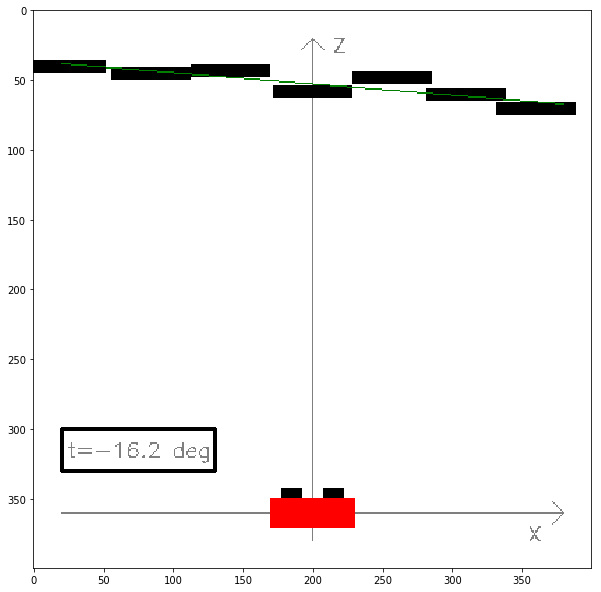

In [16]:
def drawPlanarView(norm_coords, angle):
    view = np.ones(shape=(400, 400, 3), dtype=np.int)*255     # white background
    obst_width = 400 // (len(norm_coords)*2)  # length of half the black rectangle representing the obstacle

    # Draw axis of the XZ plane
    cv2.arrowedLine(view, (200,380), (200,20), (127,127,127), 1, tipLength=0.03)
    cv2.arrowedLine(view, (20,360), (380,360), (127,127,127), 1, tipLength=0.03)
    cv2.putText(view, "X", (354,380), cv2.FONT_HERSHEY_DUPLEX, 0.5, (127,127,127), 1)
    cv2.putText(view, "Z", (214,30), cv2.FONT_HERSHEY_DUPLEX, 0.5, (127,127,127), 1)

    # Draw camera, origin coordinates (200, 360)
    cv2.rectangle(view, (170,350), (230,370), (255,0,0), thickness=cv2.FILLED)
    cv2.rectangle(view, (178,343), (192,349), (0,0,0), thickness=cv2.FILLED)
    cv2.rectangle(view, (208,343), (222,349), (0,0,0), thickness=cv2.FILLED)

    # Convert normalized coordinate
    scaled_coords = norm_coords*320+40

    # Draw the obstacles
    for c in scaled_coords:
        cv2.rectangle(view, (int(c[0]-obst_width), int(c[1]-4)), (int(c[0]+obst_width), int(c[1]+4)), (0,0,0), cv2.FILLED)

    # Write angle value in a box
    cv2.rectangle(view, (20,300), (130,330), (0,0,0), thickness=2)
    cv2.putText(view, "t={:.1f} deg".format(angle), (24,320), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (127,127,127), 1, cv2.LINE_AA)

    # Draw line through obstacles
    # The slope in the image will not correspond with the real angle computed before 
    # because the coordinates were stretched during the normalization!
    coef = np.polyfit(scaled_coords[:,0],scaled_coords[:,1],1)
    poly1d_fn = np.poly1d(coef) 
    l_start = (20, int(poly1d_fn(20)))
    l_end = (380, int(poly1d_fn(380)))
    cv2.line(view, l_start, l_end, (0,127,0), 1)

    return view

coord, angle = computeObstaclesCoords(disparity_map, 7)
planar_view = drawPlanarView(coord, angle)
plt.figure(figsize=(10,20))
plt.imshow(planar_view, "gray", vmin=0, vmax=255)
plt.show()

The camera is represented in red, located in the center of the axis, while the obstacles are represented by the black rectangles. In the bottom left is reported the angle of the general orientation of the obstacles.

Observing this particular frame, we can deduce that the robot is going toward the wall slightly sideways. The shape of the chessboard is also slightly visible, as it is closer to the camera, even if it can be a little influenced by the errors in the disparity map 

## Robust main disparity
The disparity map obtained from the previous method are not perfect, and can contain some error around occluding boundaries or in low-textured area. In this particular case, the majority of the error appears to be located inside the chessboard: this could be caused by the presence of a repetitive pattern along the epipolar lines.

Below are reported two different approaches to this problem and a combination of the two.

In [17]:
def computeRobustMainDisparity(disparity_map, mask=None):
    # If no mask is provided, compute the average across the whole disparity map
    if mask is None:
        return np.average(disparity_map)
    # If a boolean mask is provided, compute the average only in the selected area
    else:
        return np.average(disparity_map[mask])

### Moravec interest operator
I've made a first attempt by calculating the disparity only at sufficiently textured image points. In order to determine if a point was sufficiently textured, I've used the Moravec interest operator. This operator compute for each pixel the minimum directional variation: the value will be higher the more the pixel's intensity is different from the adjacent ones. To filter out the disparity, instead of choosing an arbitrary fixed threshold, the threshold is chosen based of the percentile.

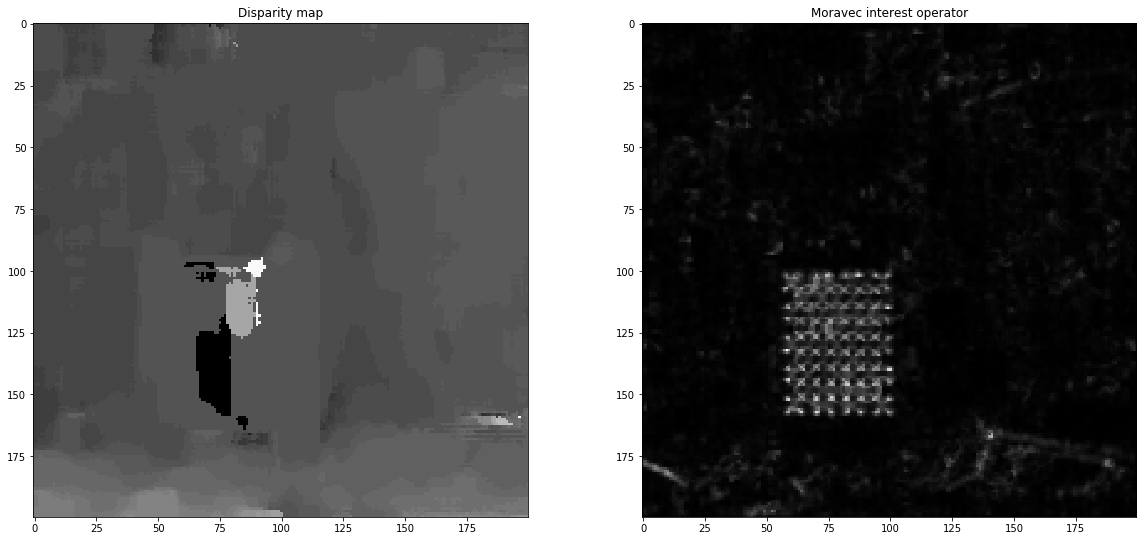

Main disparity with Moravec interest operator: 21.15


In [18]:
# def moravecOperator(image, area_size, block_size):
#
#     map = np.zeros((image.shape[0], image.shape[1]), dtype=int)
#     image_f = np.float32(image)
#    
#     n = block_size // 2      #block_size = 2n+1
#
#     v_min = (image.shape[0]-area_size)//2
#     v_max = (image.shape[0]+area_size)//2
#     u_min = (image.shape[1]-area_size)//2
#     u_max = (image.shape[1]+area_size)//2
#
#     direction = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)]
#
#     for v in range(v_min, v_max):
#         for u in range(u_min, u_max):
#             min_variation = sys.maxsize
#            
#             for i,j in direction:    # for each direction
#                 variation = SSD(image_f[v-n:v+n+1,u-n:u+n+1], image_f[v-n+j:v+n+j+1,u-n+i:u+n+i+1])
#                 if variation < min_variation:
#                     min_variation = variation
#            
#             map[v, u] = min_variation
#
#     return map[v_min:v_max, u_min:u_max]


# The following function is based on the same principle of computeFastDisparityMap, the 
# result is equivalent to that of the function above

def moravecOperator(image, area_size, block_size):

    direction = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)]
    maps = np.zeros((area_size, area_size, len(direction)), dtype=int)
    image_f = np.float32(image)
    kernel = np.ones([block_size, block_size])
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    translation = np.float32([[1, 0, -(image.shape[1]-area_size)//2], 
                              [0, 1, -(image.shape[0]-area_size)//2]])
    
    ROI = cv2.warpAffine(image_f, translation, (area_size, area_size))

    for i in range(len(direction)):
        u, v = direction[i]

        # The image is shifted in every direction
        dir_translation = translation + ([[0,0,u],[0,0,v]])
        dir_ROI = cv2.warpAffine(image_f, dir_translation, (area_size, area_size))

        # Calculate squared differences
        squared_difference = np.square(ROI - dir_ROI)

        # Convolve with kernel
        map = cv2.filter2D(
            src = squared_difference,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        maps[:, :, i] = map
    
    # The moravec operator is given by the minimum intensity variation
    return np.min(maps, axis=-1)


moravec_map = moravecOperator(frameL_gray, 200, 3)
moravec_mask = moravec_map > np.percentile(moravec_map, 70)
d_main = computeRobustMainDisparity(disparity_map, moravec_mask)

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("Disparity map")
plt.imshow(disparity_map, "gray")
plt.subplot(2,2,2)
plt.title("Moravec interest operator")
plt.imshow(moravec_map, "gray")
plt.show()

print("Main disparity with Moravec interest operator: {:.2f}".format(d_main))
    

In order to check if there is an improvement, we could recalculate the size of the chessboard, and see if they are closer to the real size.

In [19]:
W, H, _ = computeChessboardSize(frameL_gray, computeDistance(d_main))

if W != None and H != None:
    print("W - estimated: {:.2f}mm   real: 125mm".format(W))
    print("H - estimated: {:.2f}mm   real: 178mm".format(H))
else:
    print("Could not detect chessboard")

W - estimated: 125.99mm   real: 125mm
H - estimated: 183.26mm   real: 178mm


### Second best ratio
Another approach might be to analyze the dissimilarity measure along the disparity range, and find the points where there is a distinct minimum. Specifically, I've analyzed the ratio between the best and the second best minimum:
$$ \frac{f(x_{min})}{f(x_{2°min})} > TH_{RATIO} \in [0,1] $$

As before, I've chosen the threshold value based on the percentile.

Main disparity 21.18


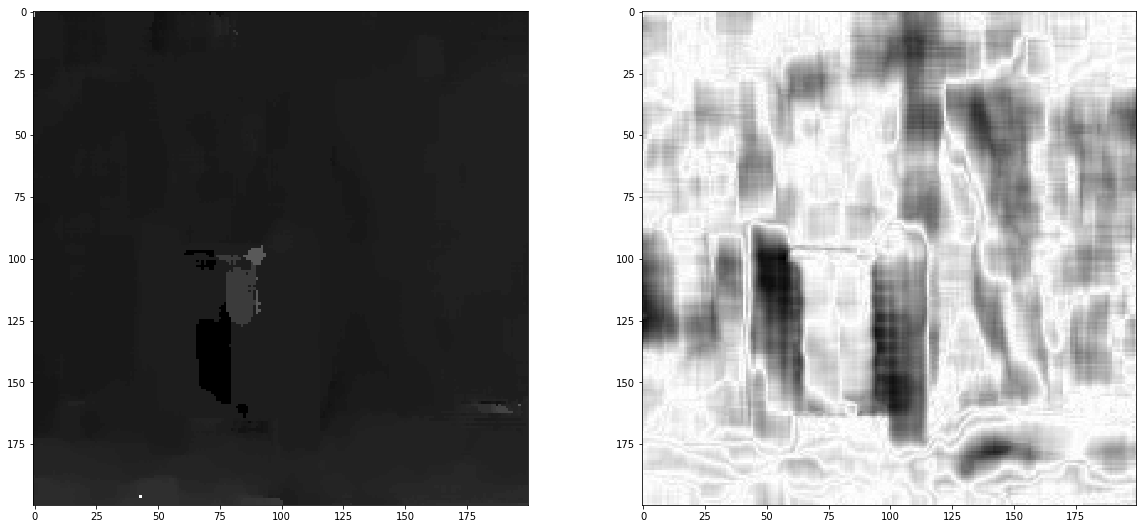

In [20]:
def secondBestRatio(dissimilarity_maps):
    map = np.zeros_like(dissimilarity_maps[:,:,0])
    for i in range(0, dissimilarity_maps.shape[0]):
        for j in range(0, dissimilarity_maps.shape[1]):
            min = np.min(dissimilarity_maps[i,j,:])
            index_min = np.argmin(dissimilarity_maps[i,j,:])
            temp = np.delete(dissimilarity_maps[i,j,:], index_min)
            second_min = np.min(temp)
            map[i,j] = min/second_min

    return map


disparity_map, sad_maps = computeFastDisparityMap(frameL_gray, frameR_gray, 200, 15, flag=R_SAD_MAPS)
ratio_map = secondBestRatio(sad_maps)
ratio_mask = ratio_map > np.percentile(ratio_map, 70)
d_main = computeRobustMainDisparity(disparity_map, ratio_mask)

print("Main disparity {:.2f}".format(d_main))

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(disparity_map, "gray")
plt.subplot(2,2,2)
plt.imshow(ratio_map, "gray")
plt.show()

In [21]:
W, H, _ = computeChessboardSize(frameL_gray, computeDistance(d_main))

if W != None and H != None:
    print("W - estimated: {:.2f}mm   real: 125mm".format(W))
    print("H - estimated: {:.2f}mm   real: 178mm".format(H))
else:
    print("Could not detect chessboard")

W - estimated: 125.83mm   real: 125mm
H - estimated: 183.02mm   real: 178mm


### Both combined
I've made another test, where I combined the two previous approach, in order to consider only sufficiently textured areas with a distinct dissimilarity minimum.

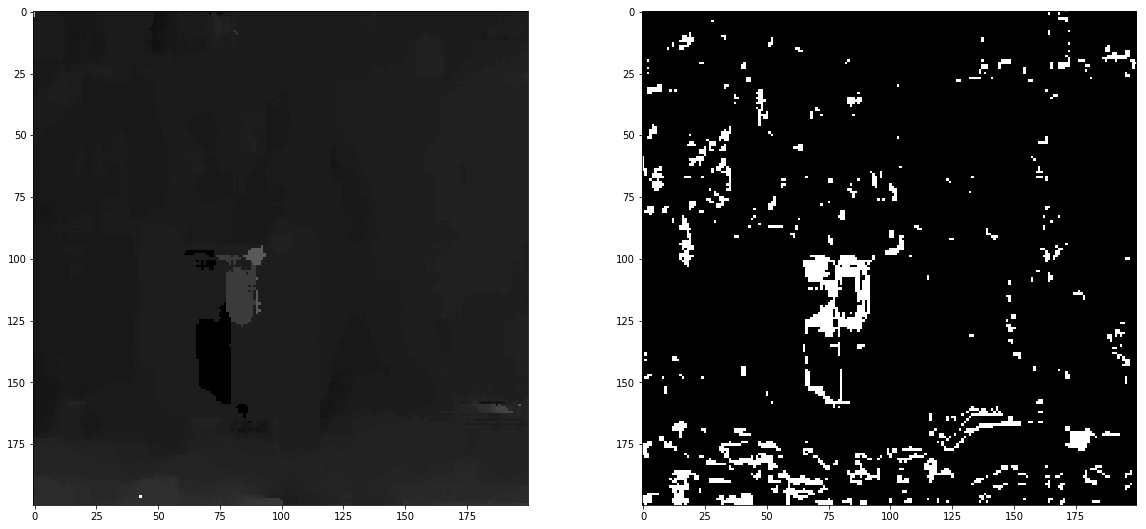

W - estimated: 121.48mm   real: 125mm
H - estimated: 176.69mm   real: 178mm


In [22]:
moravec_mask = moravec_map > np.percentile(moravec_map, 70)
ratio_mask = ratio_map > np.percentile(ratio_map, 70)
mixed_mask = np.logical_and(moravec_mask, ratio_mask)

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(disparity_map, "gray")
plt.subplot(2,2,2)
plt.imshow(mixed_mask, "gray")
plt.show()

d_main = np.average(disparity_map[mixed_mask])

W, H, _ = computeChessboardSize(frameL_gray, computeDistance(d_main))

if W != None and H != None:
    print("W - estimated: {:.2f}mm   real: 125mm".format(W))
    print("H - estimated: {:.2f}mm   real: 178mm".format(H))
else:
    print("Could not detect chessboard")

The results can vary greatly from frame to frame, depending on where the errors are located in the disparity map. Therefore, to determine which approach was the most robust in all situations, I calculated the average error over all frames of the video in **`RobustDisparityTest.ipynb`**. The most robust method was Moravec interest operator.